In [1]:
!git clone https://github.com/natanielruiz/deep-head-pose.git dhp

Cloning into 'dhp'...
remote: Enumerating objects: 11072, done.
remote: Total 11072 (delta 0), reused 0 (delta 0), pack-reused 11072
Receiving objects: 100% (11072/11072), 216.05 MiB | 20.92 MiB/s, done.
Resolving deltas: 100% (491/491), done.


In [2]:
%cd dhp

/content/dhp


In [3]:
#download weights
!gdown 1m25PrSE7g9D2q2XJVMR6IA7RaCvWSzCR

Downloading...
From: https://drive.google.com/uc?id=1m25PrSE7g9D2q2XJVMR6IA7RaCvWSzCR
To: /content/dhp/hopenet_robust_alpha1.pkl
100% 95.9M/95.9M [00:00<00:00, 118MB/s]


In [4]:
%cd code

/content/dhp/code


In [5]:
#for face detection
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 9.4 MB/s 


In [9]:
%%writefile utils.py
import numpy as np
import torch
#from torch.utils.serialization import load_lua
import os
import scipy.io as sio
import cv2
import math
from math import cos, sin

def softmax_temperature(tensor, temperature):
    result = torch.exp(tensor / temperature)
    result = torch.div(result, torch.sum(result, 1).unsqueeze(1).expand_as(result))
    return result

def get_pose_params_from_mat(mat_path):
    # This functions gets the pose parameters from the .mat
    # Annotations that come with the Pose_300W_LP dataset.
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll, tdx, tdy]
    pose_params = pre_pose_params[:5]
    return pose_params

def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params

def get_pt2d_from_mat(mat_path):
    # Get 2D landmarks
    mat = sio.loadmat(mat_path)
    pt2d = mat['pt2d']
    return pt2d

def mse_loss(input, target):
    return torch.sum(torch.abs(input.data - target.data) ** 2)

def plot_pose_cube(img, yaw, pitch, roll, tdx=None, tdy=None, size=150.):
    # Input is a cv2 image
    # pose_params: (pitch, yaw, roll, tdx, tdy)
    # Where (tdx, tdy) is the translation of the face.
    # For pose we have [pitch yaw roll tdx tdy tdz scale_factor]

    p = pitch * np.pi / 180
    y = -(yaw * np.pi / 180)
    r = roll * np.pi / 180
    if tdx != None and tdy != None:
        face_x = tdx - 0.50 * size
        face_y = tdy - 0.50 * size
    else:
        height, width = img.shape[:2]
        face_x = width / 2 - 0.5 * size
        face_y = height / 2 - 0.5 * size

    x1 = size * (cos(y) * cos(r)) + face_x
    y1 = size * (cos(p) * sin(r) + cos(r) * sin(p) * sin(y)) + face_y
    x2 = size * (-cos(y) * sin(r)) + face_x
    y2 = size * (cos(p) * cos(r) - sin(p) * sin(y) * sin(r)) + face_y
    x3 = size * (sin(y)) + face_x
    y3 = size * (-cos(y) * sin(p)) + face_y

    # Draw base in red
    cv2.line(img, (int(face_x), int(face_y)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(face_x), int(face_y)), (int(x2),int(y2)),(0,0,255),3)
    cv2.line(img, (int(x2), int(y2)), (int(x2+x1-face_x),int(y2+y1-face_y)),(0,0,255),3)
    cv2.line(img, (int(x1), int(y1)), (int(x1+x2-face_x),int(y1+y2-face_y)),(0,0,255),3)
    # Draw pillars in blue
    cv2.line(img, (int(face_x), int(face_y)), (int(x3),int(y3)),(255,0,0),2)
    cv2.line(img, (int(x1), int(y1)), (int(x1+x3-face_x),int(y1+y3-face_y)),(255,0,0),2)
    cv2.line(img, (int(x2), int(y2)), (int(x2+x3-face_x),int(y2+y3-face_y)),(255,0,0),2)
    cv2.line(img, (int(x2+x1-face_x),int(y2+y1-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(255,0,0),2)
    # Draw top in green
    cv2.line(img, (int(x3+x1-face_x),int(y3+y1-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(0,255,0),2)
    cv2.line(img, (int(x2+x3-face_x),int(y2+y3-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(0,255,0),2)
    cv2.line(img, (int(x3), int(y3)), (int(x3+x1-face_x),int(y3+y1-face_y)),(0,255,0),2)
    cv2.line(img, (int(x3), int(y3)), (int(x3+x2-face_x),int(y3+y2-face_y)),(0,255,0),2)

    return img

def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size = 100):

    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180)
    roll = roll * np.pi / 180

    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img


Overwriting utils.py


In [20]:
import sys, os, argparse

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.backends.cudnn as cudnn
import torchvision
import torch.nn.functional as F


import datasets, hopenet, utils
from mtcnn import MTCNN
import cv2

from PIL import Image
from google.colab.patches import cv2_imshow
import numpy as np



cudnn.enabled = True
gpu = 0
snapshot_path = "/content/dhp/hopenet_robust_alpha1.pkl"

# ResNet50 structure
model = hopenet.Hopenet(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], 66)


# Load snapshot
saved_state_dict = torch.load(snapshot_path)
model.load_state_dict(saved_state_dict)



transformations = transforms.Compose([transforms.Resize(224),
transforms.CenterCrop(224), transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


model.cuda(gpu)



# Test the Model
model.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
total = 0

idx_tensor = [idx for idx in range(66)]
idx_tensor = torch.FloatTensor(idx_tensor).cuda(gpu)

yaw_error = .0
pitch_error = .0
roll_error = .0

l1loss = torch.nn.L1Loss(size_average=False)
def test(path):
    img = Image.open(path)
    
    img1 = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    detector = MTCNN()
    #assuming one face
    face=detector.detect_faces(img1)[0]['box']
    x,y,w,h=face
    #print(x,y,w,h)
    
    img=img.crop((int(x-20),int(y-20),int(x+w+20),int(y+h+20)))

       
    
    img = img.convert('RGB')
    
    cv2_img=np.asarray(img)
    #
    #print(cv2_img.shape)
    cv2_img=cv2.resize(cv2_img,(224,224))[:,:,::-1]
    cv2_img = cv2_img.astype(np.uint8).copy() 
    img = transformations(img)
    
    img=img.unsqueeze(0)
    
    images = Variable(img).cuda(gpu)
    

    yaw, pitch, roll = model(images)

    # Binned predictions
    _, yaw_bpred = torch.max(yaw.data, 1)
    _, pitch_bpred = torch.max(pitch.data, 1)
    _, roll_bpred = torch.max(roll.data, 1)

    # Continuous predictions
    yaw_predicted = utils.softmax_temperature(yaw.data, 1)
    pitch_predicted = utils.softmax_temperature(pitch.data, 1)
    roll_predicted = utils.softmax_temperature(roll.data, 1)

    yaw_predicted = torch.sum(yaw_predicted * idx_tensor, 1).cpu() * 3 - 99
    pitch_predicted = torch.sum(pitch_predicted * idx_tensor, 1).cpu() * 3 - 99
    roll_predicted = torch.sum(roll_predicted * idx_tensor, 1).cpu() * 3 - 99

    
  
    pitch = pitch_predicted[0]
    yaw = -yaw_predicted[0] 
    roll = roll_predicted[0] 
    print("pitch,yaw,roll",pitch,yaw,roll)      
    utils.draw_axis(cv2_img, yaw_predicted[0], pitch_predicted[0], roll_predicted[0], size=100)
    cv2.imwrite('/content/res.jpg', cv2_img)

#put the path of your image here, result will be saved as /content/res.jpg
test("/content/a.jpg")

1/1 [==============================] - 0s 117ms/step
pitch,yaw,roll tensor(-4.7438) tensor(4.6506) tensor(-2.5348)


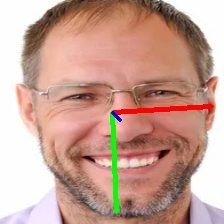

In [21]:
#view result
img=cv2.imread('/content/res.jpg')
cv2_imshow(img)
